In [1]:
!pip install lightgbm xgboost catboost optuna

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import warnings

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin, clone
from sklearn.utils import resample
from sklearn.utils.multiclass import unique_labels
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, GradientBoostingClassifier, RandomForestClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.datasets import make_classification, make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_score
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier, CatBoostRegressor
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy.special import expit

In [3]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
RANDOM_STATE=42

In [5]:
np.random.seed(42)

## Реализация бэггинга

In [6]:
class MyBaggingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator, n_estimators=10, random_state=None):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.models_ = []

    def fit(self, X, y):
        X, y = check_X_y(X, y)

        self.classes_ = unique_labels(y)

        rng = np.random.RandomState(self.random_state)

        self.models_ = []

        for _ in range(self.n_estimators):
            X_sample, y_sample = resample(X, y, random_state=rng.randint(0, int(1e6)))

            model = clone(self.base_estimator)
            model.fit(X_sample, y_sample)

            self.models_.append(model)

        return self

    def predict_proba(self, X):
        check_is_fitted(self, 'models_')
        X = check_array(X)
        probas = np.array([model.predict_proba(X) for model in self.models_])
        return np.mean(probas, axis=0)

    def predict(self, X):
        avg_proba = self.predict_proba(X)
        return self.classes_[np.argmax(avg_proba, axis=1)]

In [7]:
class MyBaggingRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, base_estimator, n_estimators=10, random_state=None):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.models_ = []

    def fit(self, X, y):
        X, y = check_X_y(X, y)

        rng = np.random.RandomState(self.random_state)

        self.models_ = []

        for _ in range(self.n_estimators):
            X_sample, y_sample = resample(X, y, random_state=rng.randint(0, int(1e6)))

            model = clone(self.base_estimator)
            model.fit(X_sample, y_sample)

            self.models_.append(model)

        return self

    def predict(self, X):
        check_is_fitted(self, 'models_')
        X = check_array(X)
        predictions = np.array([model.predict(X) for model in self.models_])
        return np.mean(predictions, axis=0)

In [8]:
def print_classification_metrics(y_true, y_pred, model_name):
    print(f"--- {model_name} ---")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
    try:
        print(f"ROC AUC: {roc_auc_score(y_true, y_pred):.4f}")
    except ValueError:
        print("ROC AUC: Cannot be computed (only one class present)")
    print()

def print_regression_metrics(y_true, y_pred, model_name):
    print(f"--- {model_name} ---")
    print(f"MSE: {mean_squared_error(y_true, y_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"R2 Score: {r2_score(y_true, y_pred):.4f}")
    print()

In [9]:
print("=== Классификация (Bagging) ===")
X_clf, y_clf = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=RANDOM_STATE)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.3, random_state=RANDOM_STATE)

base_clf = DecisionTreeClassifier(max_depth=3, random_state=RANDOM_STATE)

my_bagging_clf = MyBaggingClassifier(base_estimator=base_clf, n_estimators=50, random_state=RANDOM_STATE)
my_bagging_clf.fit(X_train_clf, y_train_clf)
my_pred_clf = my_bagging_clf.predict(X_test_clf)
print_classification_metrics(y_test_clf, my_pred_clf, "Custom BaggingClassifier")

sklearn_bagging_clf = BaggingClassifier(estimator=base_clf, n_estimators=50, random_state=RANDOM_STATE)
sklearn_bagging_clf.fit(X_train_clf, y_train_clf)
sklearn_pred_clf = sklearn_bagging_clf.predict(X_test_clf)
print_classification_metrics(y_test_clf, sklearn_pred_clf, "Sklearn BaggingClassifier")

print("\n=== Регрессия (Bagging) ===")
X_reg, y_reg = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=RANDOM_STATE)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.3, random_state=RANDOM_STATE)

base_reg = DecisionTreeRegressor(max_depth=3, random_state=RANDOM_STATE)

my_bagging_reg = MyBaggingRegressor(base_estimator=base_reg, n_estimators=50, random_state=RANDOM_STATE)
my_bagging_reg.fit(X_train_reg, y_train_reg)
my_pred_reg = my_bagging_reg.predict(X_test_reg)
print_regression_metrics(y_test_reg, my_pred_reg, "Custom BaggingRegressor")

sklearn_bagging_reg = BaggingRegressor(estimator=base_reg, n_estimators=50, random_state=RANDOM_STATE)
sklearn_bagging_reg.fit(X_train_reg, y_train_reg)
sklearn_pred_reg = sklearn_bagging_reg.predict(X_test_reg)
print_regression_metrics(y_test_reg, sklearn_pred_reg, "Sklearn BaggingRegressor")

=== Классификация (Bagging) ===
--- Custom BaggingClassifier ---
Accuracy: 0.8633
Precision: 0.8851
Recall: 0.8452
F1 Score: 0.8647
ROC AUC: 0.8640

--- Sklearn BaggingClassifier ---
Accuracy: 0.8533
Precision: 0.8828
Recall: 0.8258
F1 Score: 0.8533
ROC AUC: 0.8543


=== Регрессия (Bagging) ===
--- Custom BaggingRegressor ---
MSE: 16836.4208
MAE: 103.9201
R2 Score: 0.5589

--- Sklearn BaggingRegressor ---
MSE: 16537.7797
MAE: 104.0724
R2 Score: 0.5667



## Реализация бустинга

In [10]:
class MyGradientBoostingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator, n_estimators=100, learning_rate=0.1):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.models_ = []

    def _sigmoid(self, x):
        return expit(x)

    def fit(self, X, y):
        X, y = check_X_y(X, y)

        self.classes_ = unique_labels(y)

        if len(self.classes_) > 2:
            raise ValueError("Only binary classification is supported")

        y_binary = np.copy(y)
        if set(self.classes_) != {0, 1}:
            y_binary = np.where(y == self.classes_[1], 1, 0)

        self.models_ = []

        y_pred_proba = np.zeros_like(y_binary, dtype=float)

        for _ in range(self.n_estimators):
            proba = self._sigmoid(y_pred_proba)
            residuals = y_binary - proba

            model = clone(self.base_estimator)

            pseudo_classes = np.where(residuals >= 0, 1, 0)

            model.fit(X, pseudo_classes)

            pred = model.predict(X)
            update = 2 * pred - 1
            y_pred_proba += self.learning_rate * update

            self.models_.append(model)

        return self

    def predict_proba(self, X):
        check_is_fitted(self, 'models_')
        X = check_array(X)

        raw_scores = np.zeros(X.shape[0], dtype=float)
        for model in self.models_:
            pred = model.predict(X)
            update = 2 * pred - 1
            raw_scores += self.learning_rate * update

        probas = self._sigmoid(raw_scores)

        return np.vstack([1 - probas, probas]).T

    def predict(self, X):
        probas = self.predict_proba(X)
        return self.classes_[np.argmax(probas, axis=1)]

In [11]:
class MyGradientBoostingRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, base_estimator, n_estimators=100, learning_rate=0.1):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.models_ = []

    def fit(self, X, y):
        X, y = check_X_y(X, y)

        self.models_ = []

        y_pred = np.zeros_like(y, dtype=float)

        for _ in range(self.n_estimators):
            residuals = y - y_pred

            model = clone(self.base_estimator)
            model.fit(X, residuals)

            update = model.predict(X)
            y_pred += self.learning_rate * update

            self.models_.append(model)

        return self

    def predict(self, X):
        check_is_fitted(self, 'models_')

        X = check_array(X)

        y_pred = np.zeros(X.shape[0], dtype=float)

        for model in self.models_:
            y_pred += self.learning_rate * model.predict(X)

        return y_pred

In [12]:
print("=== Классификация (Boosting) ===")
X_clf, y_clf = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=RANDOM_STATE)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.3, random_state=RANDOM_STATE)

base_clf = DecisionTreeClassifier(max_depth=3, random_state=RANDOM_STATE)

my_gb_clf = MyGradientBoostingClassifier(base_estimator=base_clf, n_estimators=50, learning_rate=0.1)
my_gb_clf.fit(X_train_clf, y_train_clf)
my_pred_clf = my_gb_clf.predict(X_test_clf)
print_classification_metrics(y_test_clf, my_pred_clf, "Custom GradientBoostingClassifier")

sklearn_gb_clf = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=RANDOM_STATE)
sklearn_gb_clf.fit(X_train_clf, y_train_clf)
sklearn_pred_clf = sklearn_gb_clf.predict(X_test_clf)
print_classification_metrics(y_test_clf, sklearn_pred_clf, "Sklearn GradientBoostingClassifier")

xgb_clf = XGBClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=RANDOM_STATE)
xgb_clf.fit(X_train_clf, y_train_clf)
xgb_pred_clf = xgb_clf.predict(X_test_clf)
print_classification_metrics(y_test_clf, xgb_pred_clf, "XGBoost")

lgb_clf = LGBMClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, verbosity=-1, random_state=RANDOM_STATE)
lgb_clf.fit(X_train_clf, y_train_clf)
lgb_pred_clf = lgb_clf.predict(X_test_clf)
print_classification_metrics(y_test_clf, lgb_pred_clf, "LightGBM")

cat_clf = CatBoostClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=RANDOM_STATE, verbose=0)
cat_clf.fit(X_train_clf, y_train_clf)
cat_pred_clf = cat_clf.predict(X_test_clf)
print_classification_metrics(y_test_clf, cat_pred_clf, "CatBoost")

print("\n=== Регрессия (Boosting) ===")
X_reg, y_reg = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=RANDOM_STATE)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.3, random_state=RANDOM_STATE)

base_reg = DecisionTreeRegressor(max_depth=3, random_state=RANDOM_STATE)

my_gb_reg = MyGradientBoostingRegressor(base_estimator=base_reg, n_estimators=50, learning_rate=0.1)
my_gb_reg.fit(X_train_reg, y_train_reg)
my_pred_reg = my_gb_reg.predict(X_test_reg)
print_regression_metrics(y_test_reg, my_pred_reg, "Custom GradientBoostingRegressor")

sklearn_gb_reg = GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=RANDOM_STATE)
sklearn_gb_reg.fit(X_train_reg, y_train_reg)
sklearn_pred_reg = sklearn_gb_reg.predict(X_test_reg)
print_regression_metrics(y_test_reg, sklearn_pred_reg, "Sklearn GradientBoostingRegressor")

xgb_reg = XGBRegressor(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=RANDOM_STATE)
xgb_reg.fit(X_train_reg, y_train_reg)
xgb_pred_reg = xgb_reg.predict(X_test_reg)
print_regression_metrics(y_test_reg, xgb_pred_reg, "XGBoost")

lgb_reg = LGBMRegressor(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=RANDOM_STATE)
lgb_reg.fit(X_train_reg, y_train_reg)
lgb_pred_reg = lgb_reg.predict(X_test_reg)
print_regression_metrics(y_test_reg, lgb_pred_reg, "LightGBM")

cat_reg = CatBoostRegressor(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=RANDOM_STATE, verbose=0)
cat_reg.fit(X_train_reg, y_train_reg)
cat_pred_reg = cat_reg.predict(X_test_reg)
print_regression_metrics(y_test_reg, cat_pred_reg, "CatBoost")


=== Классификация (Boosting) ===
--- Custom GradientBoostingClassifier ---
Accuracy: 0.8400
Precision: 0.8905
Recall: 0.7871
F1 Score: 0.8356
ROC AUC: 0.8418

--- Sklearn GradientBoostingClassifier ---
Accuracy: 0.8667
Precision: 0.8859
Recall: 0.8516
F1 Score: 0.8684
ROC AUC: 0.8672

--- XGBoost ---
Accuracy: 0.8667
Precision: 0.8912
Recall: 0.8452
F1 Score: 0.8675
ROC AUC: 0.8674

--- LightGBM ---
Accuracy: 0.8667
Precision: 0.8966
Recall: 0.8387
F1 Score: 0.8667
ROC AUC: 0.8676

--- CatBoost ---
Accuracy: 0.8633
Precision: 0.8750
Recall: 0.8581
F1 Score: 0.8664
ROC AUC: 0.8635


=== Регрессия (Boosting) ===
--- Custom GradientBoostingRegressor ---
MSE: 5771.9037
MAE: 59.0466
R2 Score: 0.8488

--- Sklearn GradientBoostingRegressor ---
MSE: 5767.4113
MAE: 59.0347
R2 Score: 0.8489

--- XGBoost ---
MSE: 5683.1052
MAE: 58.7140
R2 Score: 0.8511

--- LightGBM ---
MSE: 5918.0879
MAE: 60.7225
R2 Score: 0.8449

--- CatBoost ---
MSE: 5509.7413
MAE: 57.3006
R2 Score: 0.8556



## Реализация метрик

In [13]:
def my_accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

def my_precision(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    return tp / (tp + fp) if (tp + fp) > 0 else 0.0

def my_recall(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return tp / (tp + fn) if (tp + fn) > 0 else 0.0

def my_f1(y_true, y_pred):
    p = my_precision(y_true, y_pred)
    r = my_recall(y_true, y_pred)
    return 2 * p * r / (p + r) if (p + r) > 0 else 0.0

def my_roc_auc(y_true, y_pred_proba):
    def roc_curve_manual(y_true, y_score):
        thresholds = np.sort(np.unique(y_score))[::-1]
        tpr = []
        fpr = []
        P = np.sum(y_true == 1)
        N = np.sum(y_true == 0)

        for thresh in thresholds:
            y_pred = (y_score >= thresh).astype(int)
            tp = np.sum((y_pred == 1) & (y_true == 1))
            fp = np.sum((y_pred == 1) & (y_true == 0))
            tpr.append(tp / P if P else 0)
            fpr.append(fp / N if N else 0)

        return np.array(fpr), np.array(tpr), thresholds

    fpr, tpr, _ = roc_curve_manual(y_true, y_pred_proba)
    return np.trapezoid(tpr, fpr)

def my_auc_pr(y_true, y_pred_proba):
    def precision_recall_curve_manual(y_true, y_score):
        thresholds = np.sort(np.unique(y_score))[::-1]
        precisions = []
        recalls = []

        for thresh in thresholds:
            y_pred = (y_score >= thresh).astype(int)
            precisions.append(my_precision(y_true, y_pred))
            recalls.append(my_recall(y_true, y_pred))

        return np.array(precisions), np.array(recalls), thresholds

    precision_vals, recall_vals, _ = precision_recall_curve_manual(y_true, y_pred_proba)
    return np.trapezoid(precision_vals, recall_vals)

In [14]:
y_true = np.random.randint(0, 2, size=1000)
y_pred = np.random.randint(0, 2, size=1000)
y_pred_proba = np.random.rand(1000)

print("Accuracy:")
print("  Custom:", my_accuracy(y_true, y_pred))
print("  Sklearn:", accuracy_score(y_true, y_pred))

print("\nPrecision:")
print("  Custom:", my_precision(y_true, y_pred))
print("  Sklearn:", precision_score(y_true, y_pred))

print("\nRecall:")
print("  Custom:", my_recall(y_true, y_pred))
print("  Sklearn:", recall_score(y_true, y_pred))

print("\nF1-score:")
print("  Custom:", my_f1(y_true, y_pred))
print("  Sklearn:", f1_score(y_true, y_pred))

print("\nAUC-ROC:")
print("  Custom:", my_roc_auc(y_true, y_pred_proba))
print("  Sklearn:", roc_auc_score(y_true, y_pred_proba))

print("\nAUC-PR:")
print("  СCustom:", my_auc_pr(y_true, y_pred_proba))
print("  Sklearn:", average_precision_score(y_true, y_pred_proba))

Accuracy:
  Custom: 0.502
  Sklearn: 0.502

Precision:
  Custom: 0.5126582278481012
  Sklearn: 0.5126582278481012

Recall:
  Custom: 0.4764705882352941
  Sklearn: 0.4764705882352941

F1-score:
  Custom: 0.49390243902439024
  Sklearn: 0.49390243902439024

AUC-ROC:
  Custom: 0.5315246098439376
  Sklearn: 0.5315246098439377

AUC-PR:
  СCustom: 0.5219151964196387
  Sklearn: 0.5252984103936756


## Загрузка данных

In [15]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [16]:
display(train.head(), test.head())

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55.0,150.0,50.0,73.0,0.8,1.0,1.0,1.0,122.0,...,62.0,113.0,12.0,1.0,0.6,22.0,21.0,12.0,0.0,0.0
1,1,50.0,160.0,60.0,79.6,1.0,0.8,1.0,1.0,124.0,...,74.0,112.0,14.1,1.0,0.9,19.0,14.0,17.0,0.0,0.0
2,2,55.0,145.0,50.0,73.0,1.2,1.2,1.0,1.0,110.0,...,66.0,123.0,13.3,1.0,0.6,15.0,12.0,13.0,0.0,0.0
3,3,40.0,175.0,80.0,83.2,0.9,1.0,1.0,1.0,99.0,...,38.0,114.0,16.1,1.0,1.0,22.0,13.0,20.0,0.0,1.0
4,4,30.0,170.0,70.0,79.5,1.2,1.2,1.0,1.0,119.0,...,49.0,148.0,15.5,1.0,1.2,18.0,19.0,25.0,0.0,1.0


,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
0,15000,40.0,155.0,45.0,64.0,0.9,0.9,1.0,1.0,109.0,...,50.0,79.0,108.0,13.3,1.0,0.9,16.0,11.0,17.0,0.0
1,15001,45.0,175.0,90.0,101.0,1.0,1.2,1.0,1.0,130.0,...,147.0,38.0,99.0,16.2,1.0,0.9,23.0,21.0,28.0,1.0
2,15002,40.0,165.0,60.0,78.0,1.5,1.5,1.0,1.0,107.0,...,60.0,67.0,136.0,14.9,1.0,0.9,30.0,36.0,16.0,0.0
3,15003,35.0,170.0,60.0,84.5,1.0,1.0,1.0,1.0,124.0,...,127.0,63.0,128.0,15.4,1.0,0.8,21.0,17.0,26.0,1.0
4,15004,40.0,155.0,45.0,68.5,1.0,1.0,1.0,1.0,109.0,...,47.0,61.0,133.0,11.5,1.0,0.7,22.0,12.0,17.0,0.0


## EDA

### Первичный осмотр

In [17]:
train.shape

(15000, 24)

In [18]:
test.shape

(10000, 23)

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   15000 non-null  int64  
 1   age                  15000 non-null  float64
 2   height(cm)           15000 non-null  float64
 3   weight(kg)           15000 non-null  float64
 4   waist(cm)            15000 non-null  float64
 5   eyesight(left)       15000 non-null  float64
 6   eyesight(right)      15000 non-null  float64
 7   hearing(left)        15000 non-null  float64
 8   hearing(right)       15000 non-null  float64
 9   systolic             15000 non-null  float64
 10  relaxation           15000 non-null  float64
 11  fasting blood sugar  15000 non-null  float64
 12  Cholesterol          15000 non-null  float64
 13  triglyceride         15000 non-null  float64
 14  HDL                  15000 non-null  float64
 15  LDL                  15000 non-null 

In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   10000 non-null  int64  
 1   age                  10000 non-null  float64
 2   height(cm)           10000 non-null  float64
 3   weight(kg)           10000 non-null  float64
 4   waist(cm)            10000 non-null  float64
 5   eyesight(left)       10000 non-null  float64
 6   eyesight(right)      10000 non-null  float64
 7   hearing(left)        10000 non-null  float64
 8   hearing(right)       10000 non-null  float64
 9   systolic             10000 non-null  float64
 10  relaxation           10000 non-null  float64
 11  fasting blood sugar  10000 non-null  float64
 12  Cholesterol          10000 non-null  float64
 13  triglyceride         10000 non-null  float64
 14  HDL                  10000 non-null  float64
 15  LDL                  10000 non-null  

In [21]:
train.describe()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,...,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7499.500000,42.606000,164.672667,64.282000,80.323180,1.032727,1.025927,1.005533,1.004933,119.149467,...,57.535667,113.158533,14.510340,1.016533,0.866580,22.272667,20.874933,26.290200,0.139467,0.366600
std,4330.271354,10.415341,8.558684,10.973871,7.932701,0.312845,0.313488,0.074183,0.070067,11.167046,...,11.380739,18.442012,1.392921,0.157464,0.168492,6.324422,10.314009,20.431882,0.346444,0.481892
min,0.000000,20.000000,140.000000,35.000000,0.900000,0.100000,0.100000,1.000000,1.000000,82.000000,...,28.000000,41.000000,7.200000,1.000000,0.100000,9.000000,4.000000,6.000000,0.000000,0.000000
25%,3749.750000,40.000000,160.000000,55.000000,75.000000,0.800000,0.800000,1.000000,1.000000,110.000000,...,49.000000,100.000000,13.500000,1.000000,0.800000,18.000000,14.000000,15.000000,0.000000,0.000000
50%,7499.500000,40.000000,165.000000,65.000000,80.000000,1.000000,1.000000,1.000000,1.000000,119.000000,...,56.000000,112.000000,14.700000,1.000000,0.900000,21.000000,18.000000,21.000000,0.000000,0.000000
75%,11249.250000,50.000000,170.000000,70.000000,86.000000,1.200000,1.200000,1.000000,1.000000,128.000000,...,65.000000,126.000000,15.600000,1.000000,1.000000,25.000000,24.000000,31.000000,0.000000,1.000000
max,14999.000000,80.000000,190.000000,120.000000,121.000000,9.900000,9.900000,2.000000,2.000000,190.000000,...,105.000000,193.000000,28.900000,5.000000,1.600000,324.000000,190.000000,566.000000,1.000000,1.000000


In [22]:
train.duplicated().sum()

np.int64(0)

In [23]:
test.duplicated().sum()

np.int64(0)

### Анализ признаков

Percentage of smokers: 36.66%


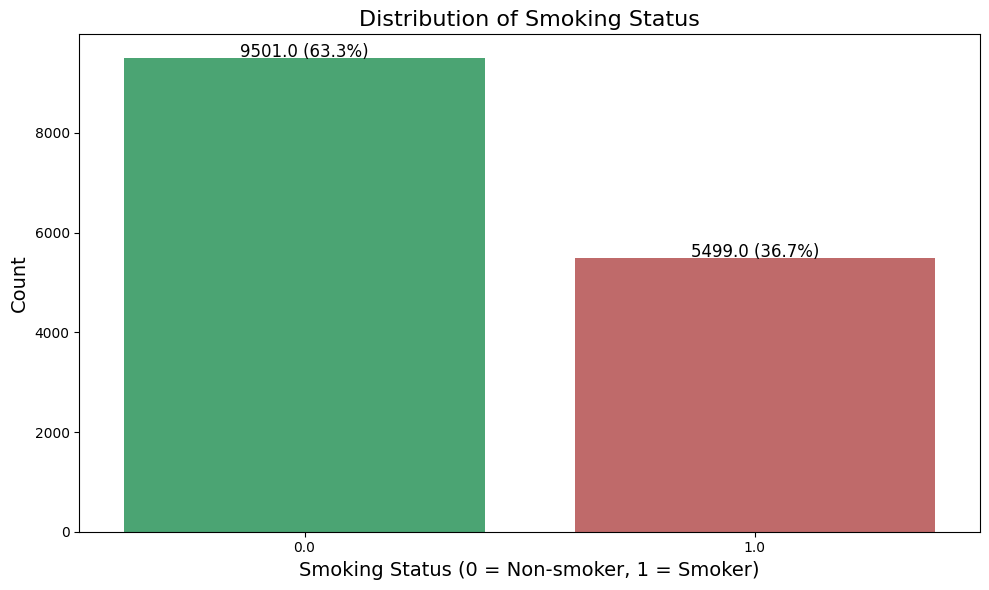

In [24]:
smoking_count = train['smoking'].value_counts()
print(f"Percentage of smokers: {smoking_count[1]/len(train)*100:.2f}%")

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='smoking', data=train, palette=['#3CB371', '#CD5C5C'])
plt.title('Distribution of Smoking Status', fontsize=16)
plt.xlabel('Smoking Status (0 = Non-smoker, 1 = Smoker)', fontsize=14)
plt.ylabel('Count', fontsize=14)

total = len(train)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 20,
            f'{height} ({height/total*100:.1f}%)',
            ha="center", fontsize=12)

plt.tight_layout()
plt.show()

Таргет имеет явный дизбаланс классов

In [25]:
def is_categorical(s, threshold=10):
    return s.nunique() < threshold

In [26]:
categorical_features = [col for col in train.columns if is_categorical(train[col])]
continuous_features = [col for col in train.drop(columns=['id']).columns if col not in categorical_features and col != 'smoking']

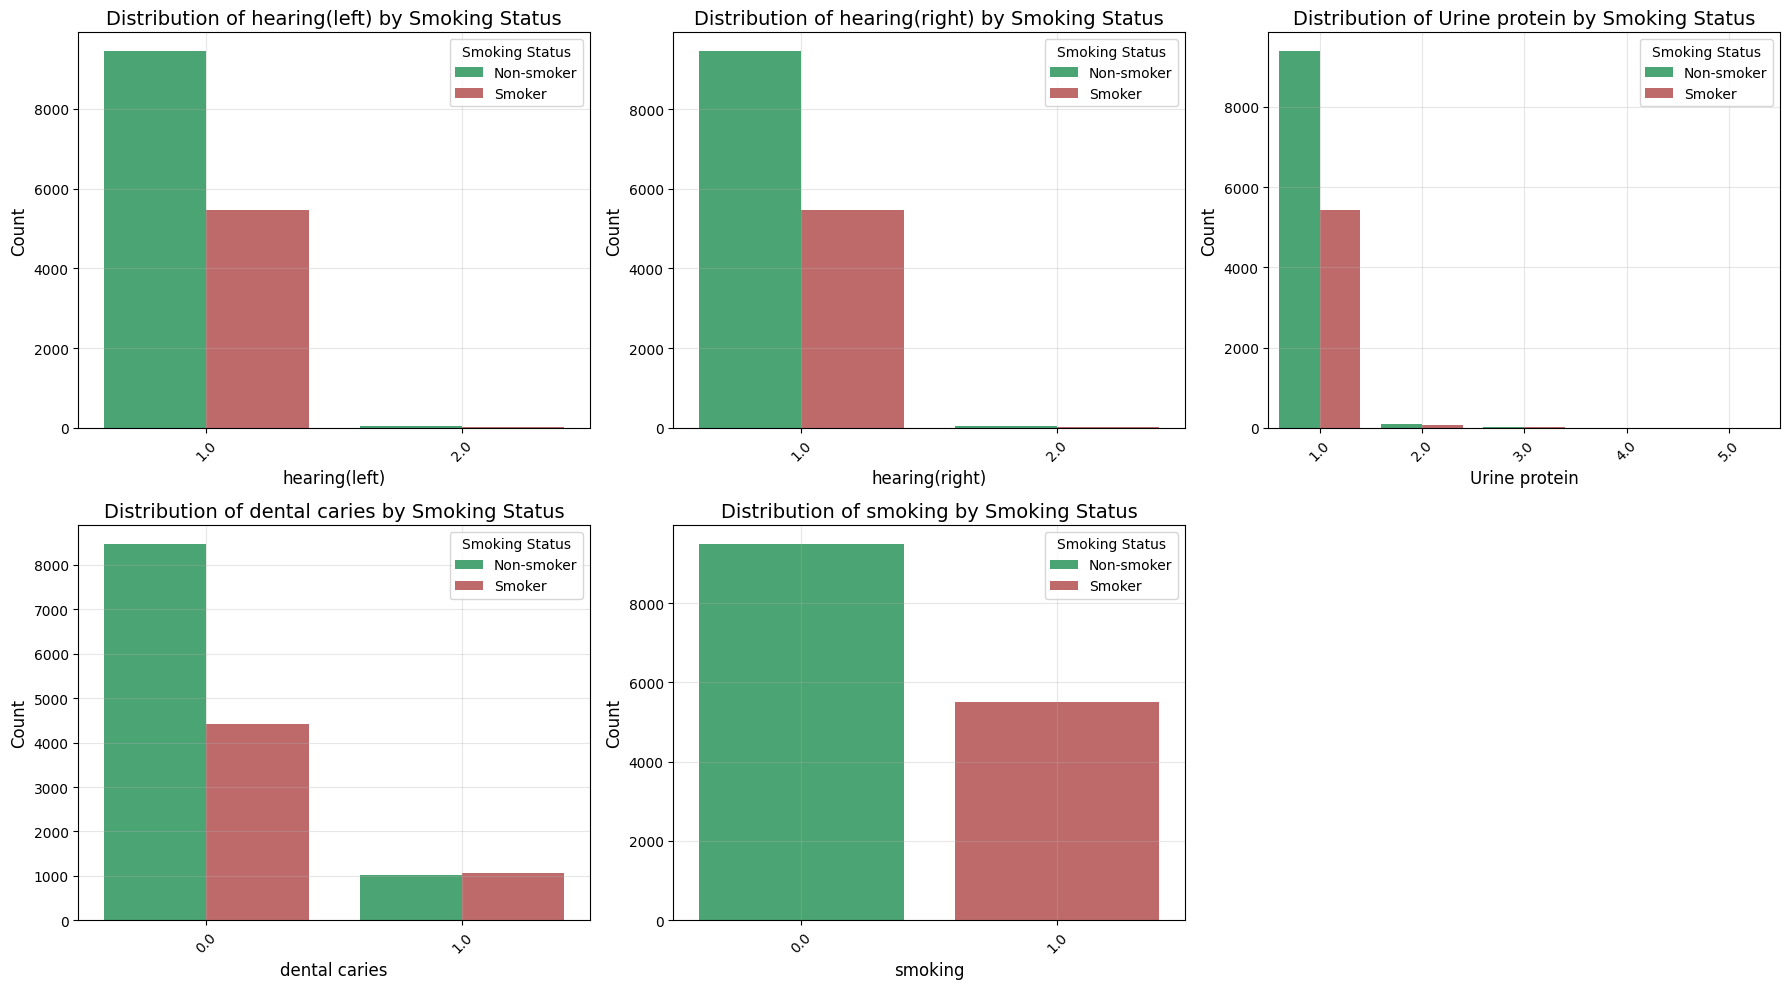

In [27]:
n_cats = len(categorical_features)
rows = int(np.ceil(n_cats / 3))
plt.figure(figsize=(18, rows * 5))

for i, feature in enumerate(categorical_features, 1):
    plt.subplot(rows, 3, i)
    sns.countplot(x=feature, hue='smoking', data=train, palette=['#3CB371', '#CD5C5C'])
    plt.title(f'Distribution of {feature} by Smoking Status', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(['Non-smoker', 'Smoker'], title='Smoking Status')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

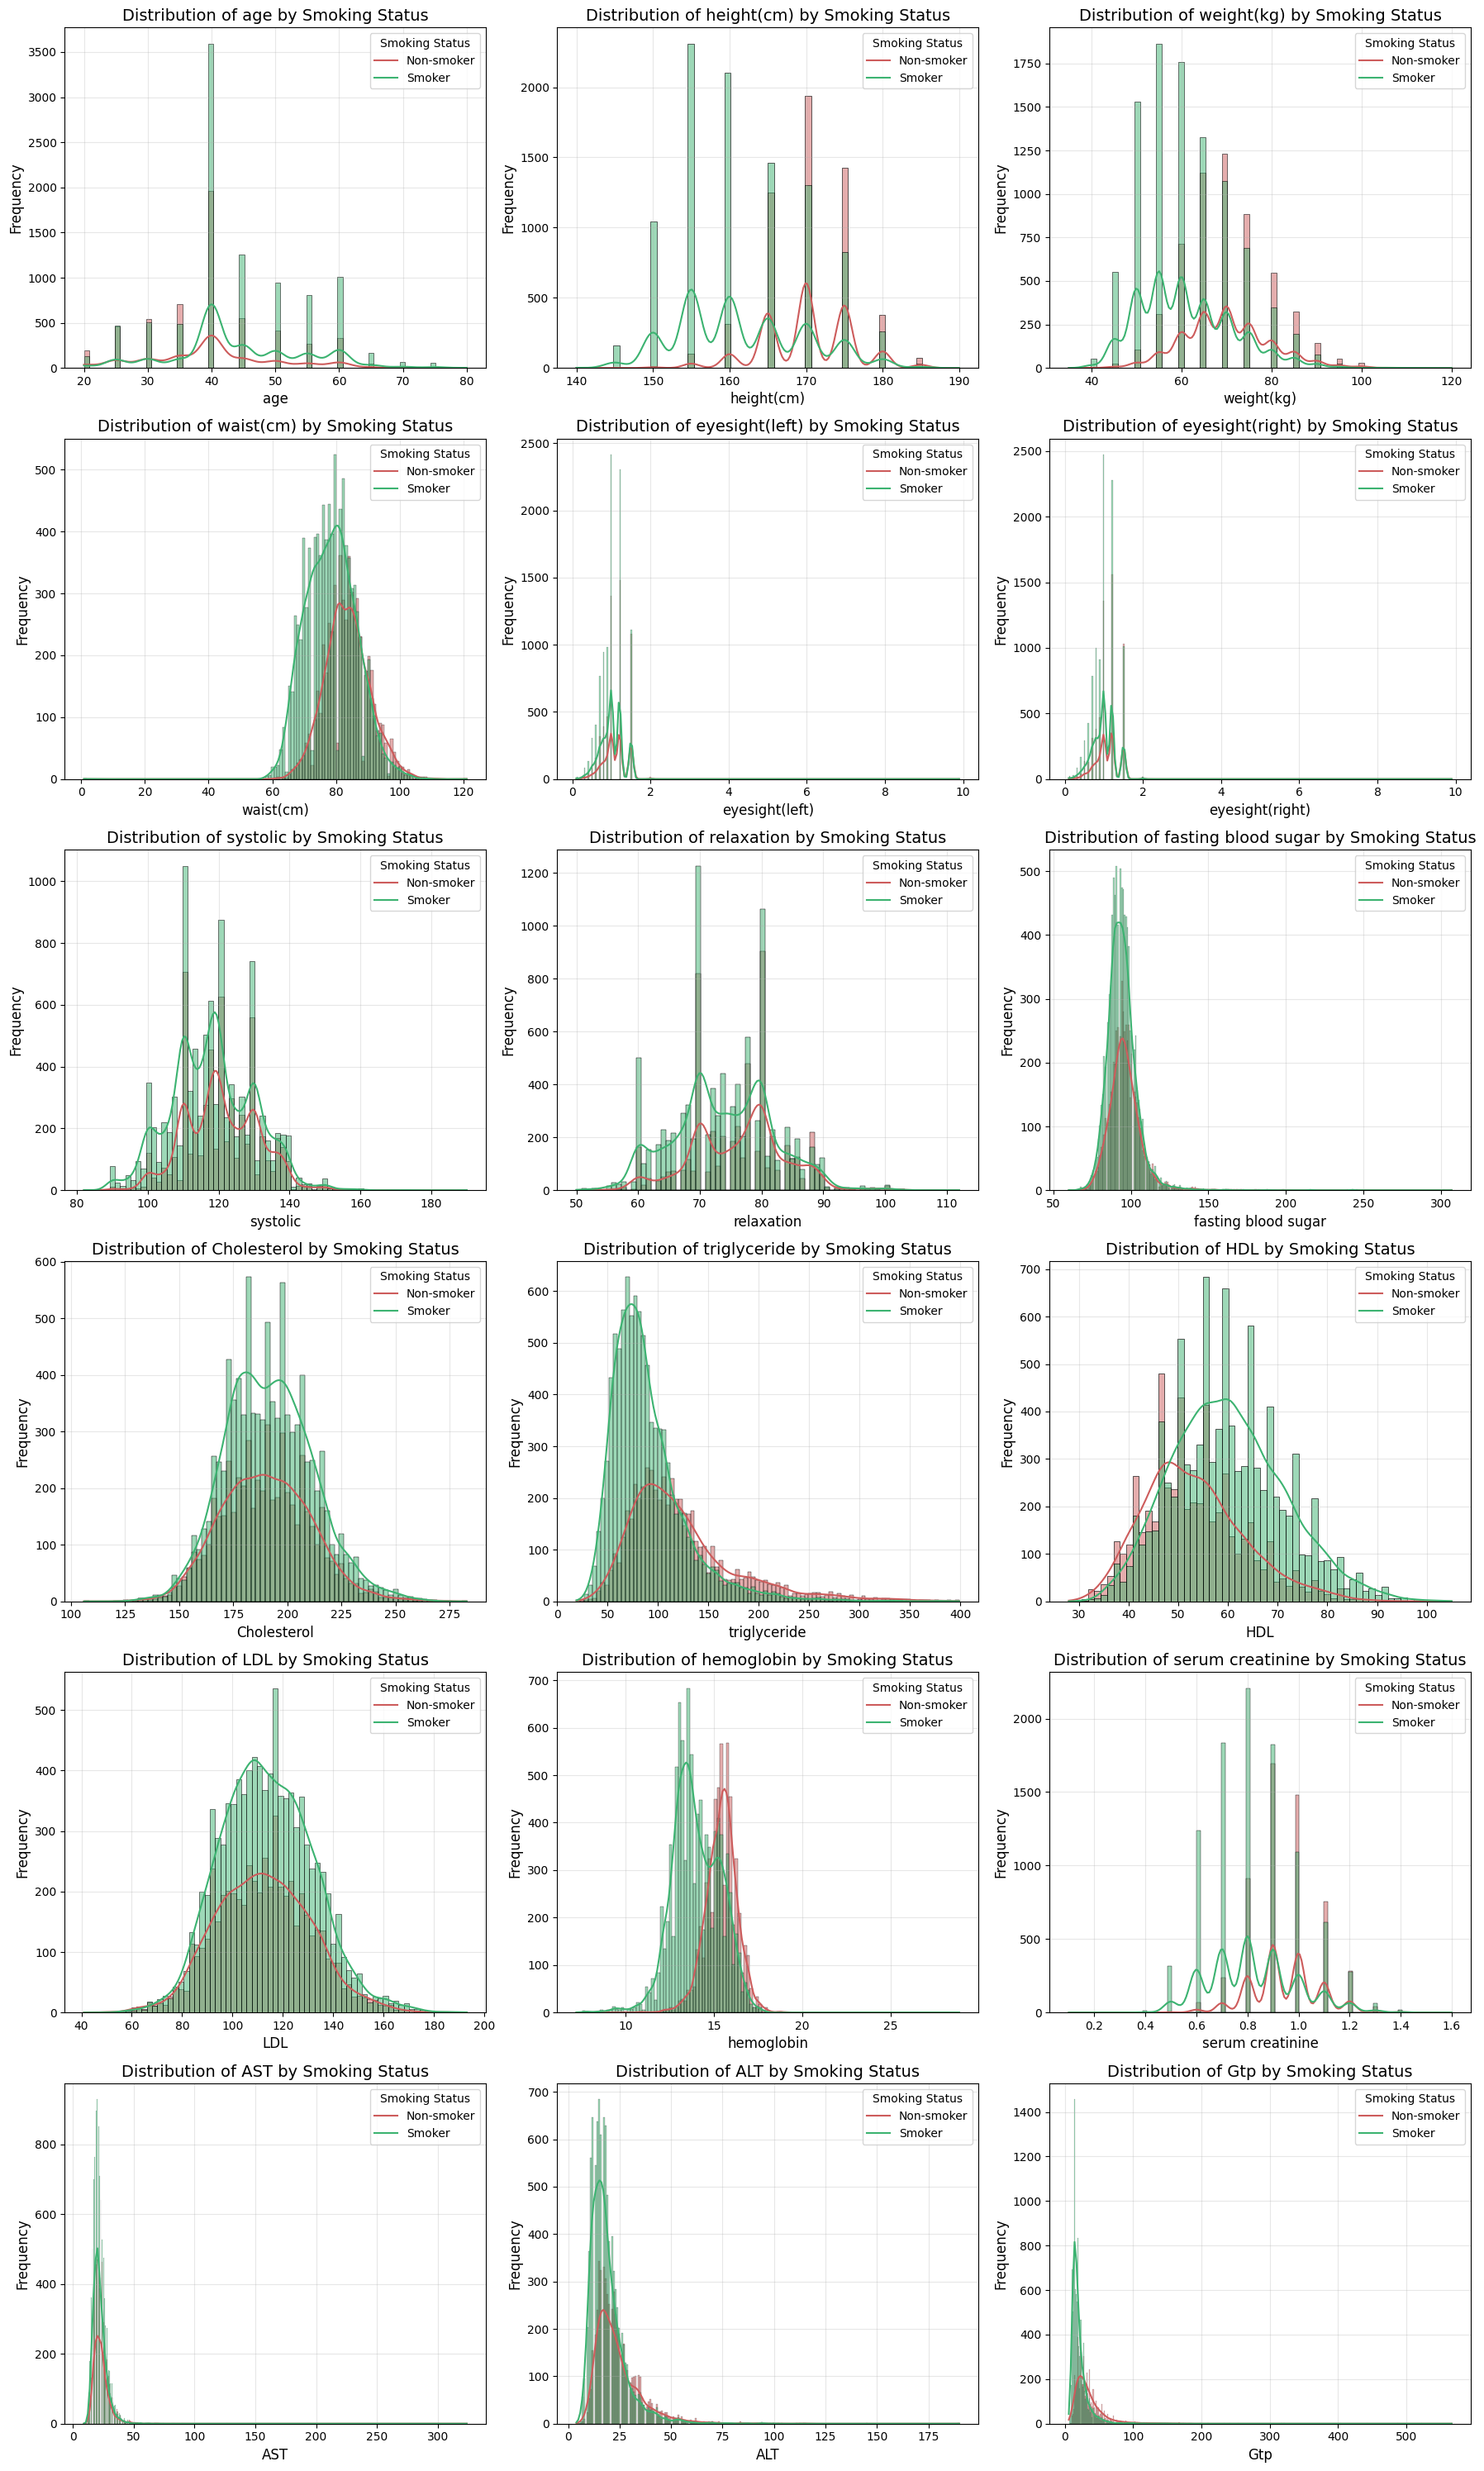

In [28]:
n_conts = len(continuous_features)
rows = int(np.ceil(n_conts / 3))
plt.figure(figsize=(18, rows * 5))

for i, feature in enumerate(continuous_features, 1):
    plt.subplot(rows, 3, i)
    sns.histplot(data=train, x=feature, hue='smoking', kde=True, palette=['#3CB371', '#CD5C5C'])
    plt.title(f'Distribution of {feature} by Smoking Status', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(['Non-smoker', 'Smoker'], title='Smoking Status')

plt.tight_layout()
plt.show()

Много признаков имеют скошенные распределения, сохраним их, для дальнейшей обработки.

In [29]:
train_without_target = train.drop(columns=['smoking'])

num_cols = train_without_target.select_dtypes(include=['number']).columns.tolist()
skewed = train_without_target[num_cols].skew().sort_values(ascending=False)
skewed_cols = skewed[skewed > 0.8].index.tolist()

skewed_cols

['hearing(right)',
 'hearing(left)',
 'Urine protein',
 'AST',
 'Gtp',
 'eyesight(left)',
 'eyesight(right)',
 'fasting blood sugar',
 'ALT',
 'dental caries',
 'triglyceride']

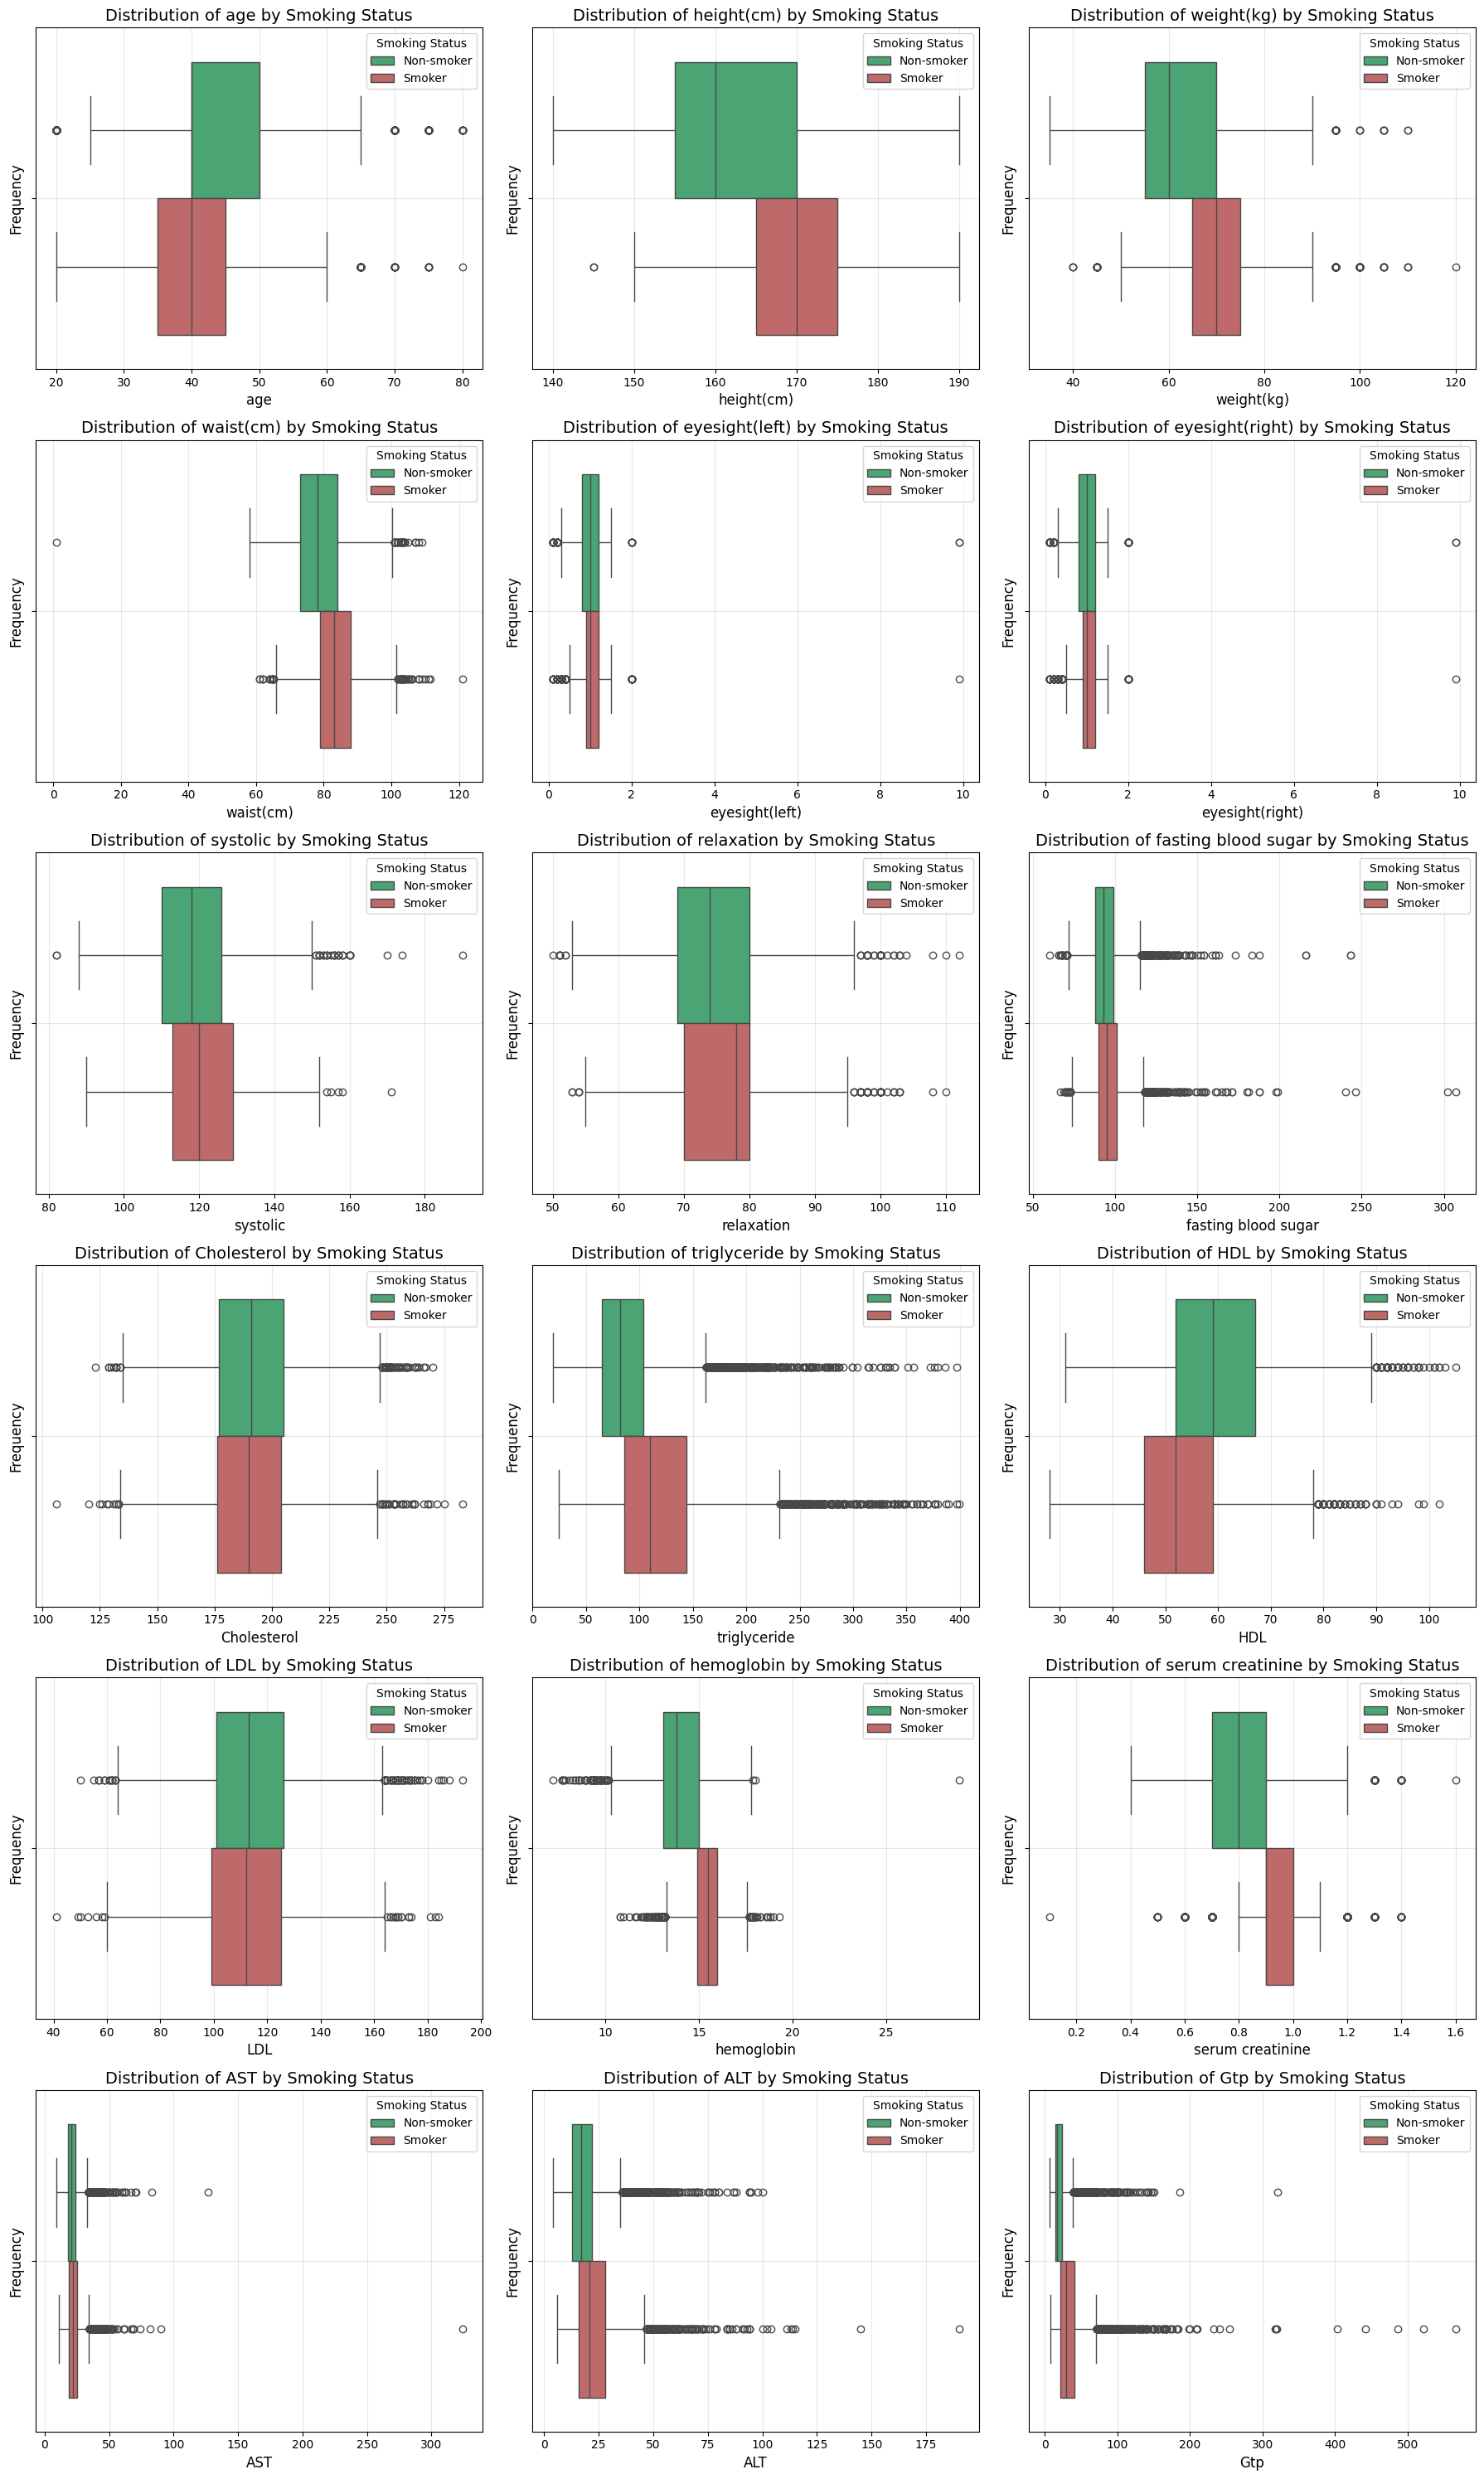

In [30]:
n_conts = len(continuous_features)
rows = int(np.ceil(n_conts / 3))
plt.figure(figsize=(18, rows * 5))

for i, feature in enumerate(continuous_features, 1):
    plt.subplot(rows, 3, i)
    sns.boxplot(data=train, x=feature, hue='smoking', palette=['#3CB371', '#CD5C5C'])
    plt.title(f'Distribution of {feature} by Smoking Status', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(['Non-smoker', 'Smoker'], title='Smoking Status')

plt.tight_layout()
plt.show()

Сохраним значения признаков между 1% и 99% квантилями.


Correlations with Smoking Status:
smoking                1.000000
hemoglobin             0.495122
height(cm)             0.486249
weight(kg)             0.397177
serum creatinine       0.349368
Gtp                    0.344240
triglyceride           0.340708
waist(cm)              0.303364
ALT                    0.238512
relaxation             0.150832
eyesight(right)        0.133207
dental caries          0.121432
eyesight(left)         0.119642
systolic               0.115470
fasting blood sugar    0.092369
AST                    0.089114
Urine protein          0.014131
id                     0.009458
hearing(right)        -0.000254
hearing(left)         -0.004528
Cholesterol           -0.035048
LDL                   -0.035168
age                   -0.196801
HDL                   -0.291101
Name: smoking, dtype: float64


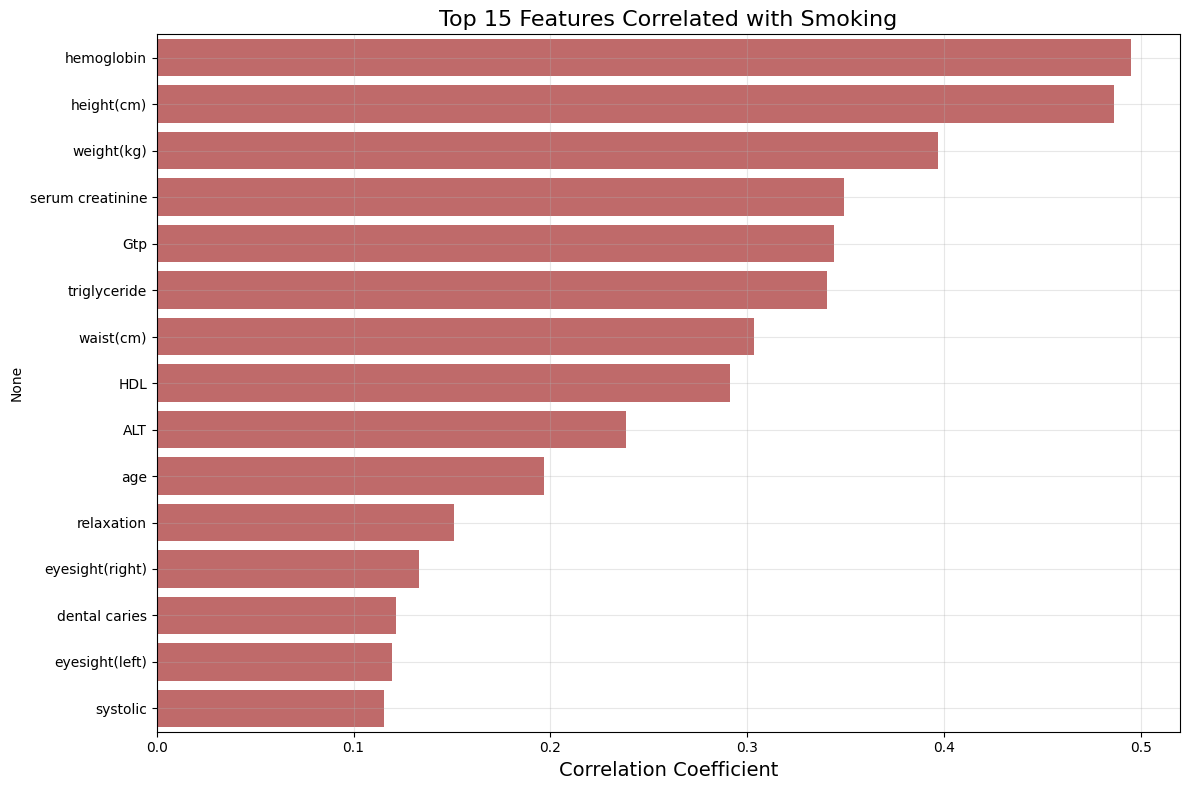

In [31]:
correlations_with_target = train.corr()['smoking'].sort_values(ascending=False)
print("\nCorrelations with Smoking Status:")
print(correlations_with_target)

plt.figure(figsize=(12, 8))
top_corr = correlations_with_target[correlations_with_target.index != 'smoking']
top_corr = top_corr.abs().sort_values(ascending=False).head(15)
colors = ['#CD5C5C' if x > 0 else '#3CB371' for x in top_corr]
sns.barplot(x=top_corr.values, y=top_corr.index, palette=colors)
plt.title('Top 15 Features Correlated with Smoking', fontsize=16)
plt.xlabel('Correlation Coefficient', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

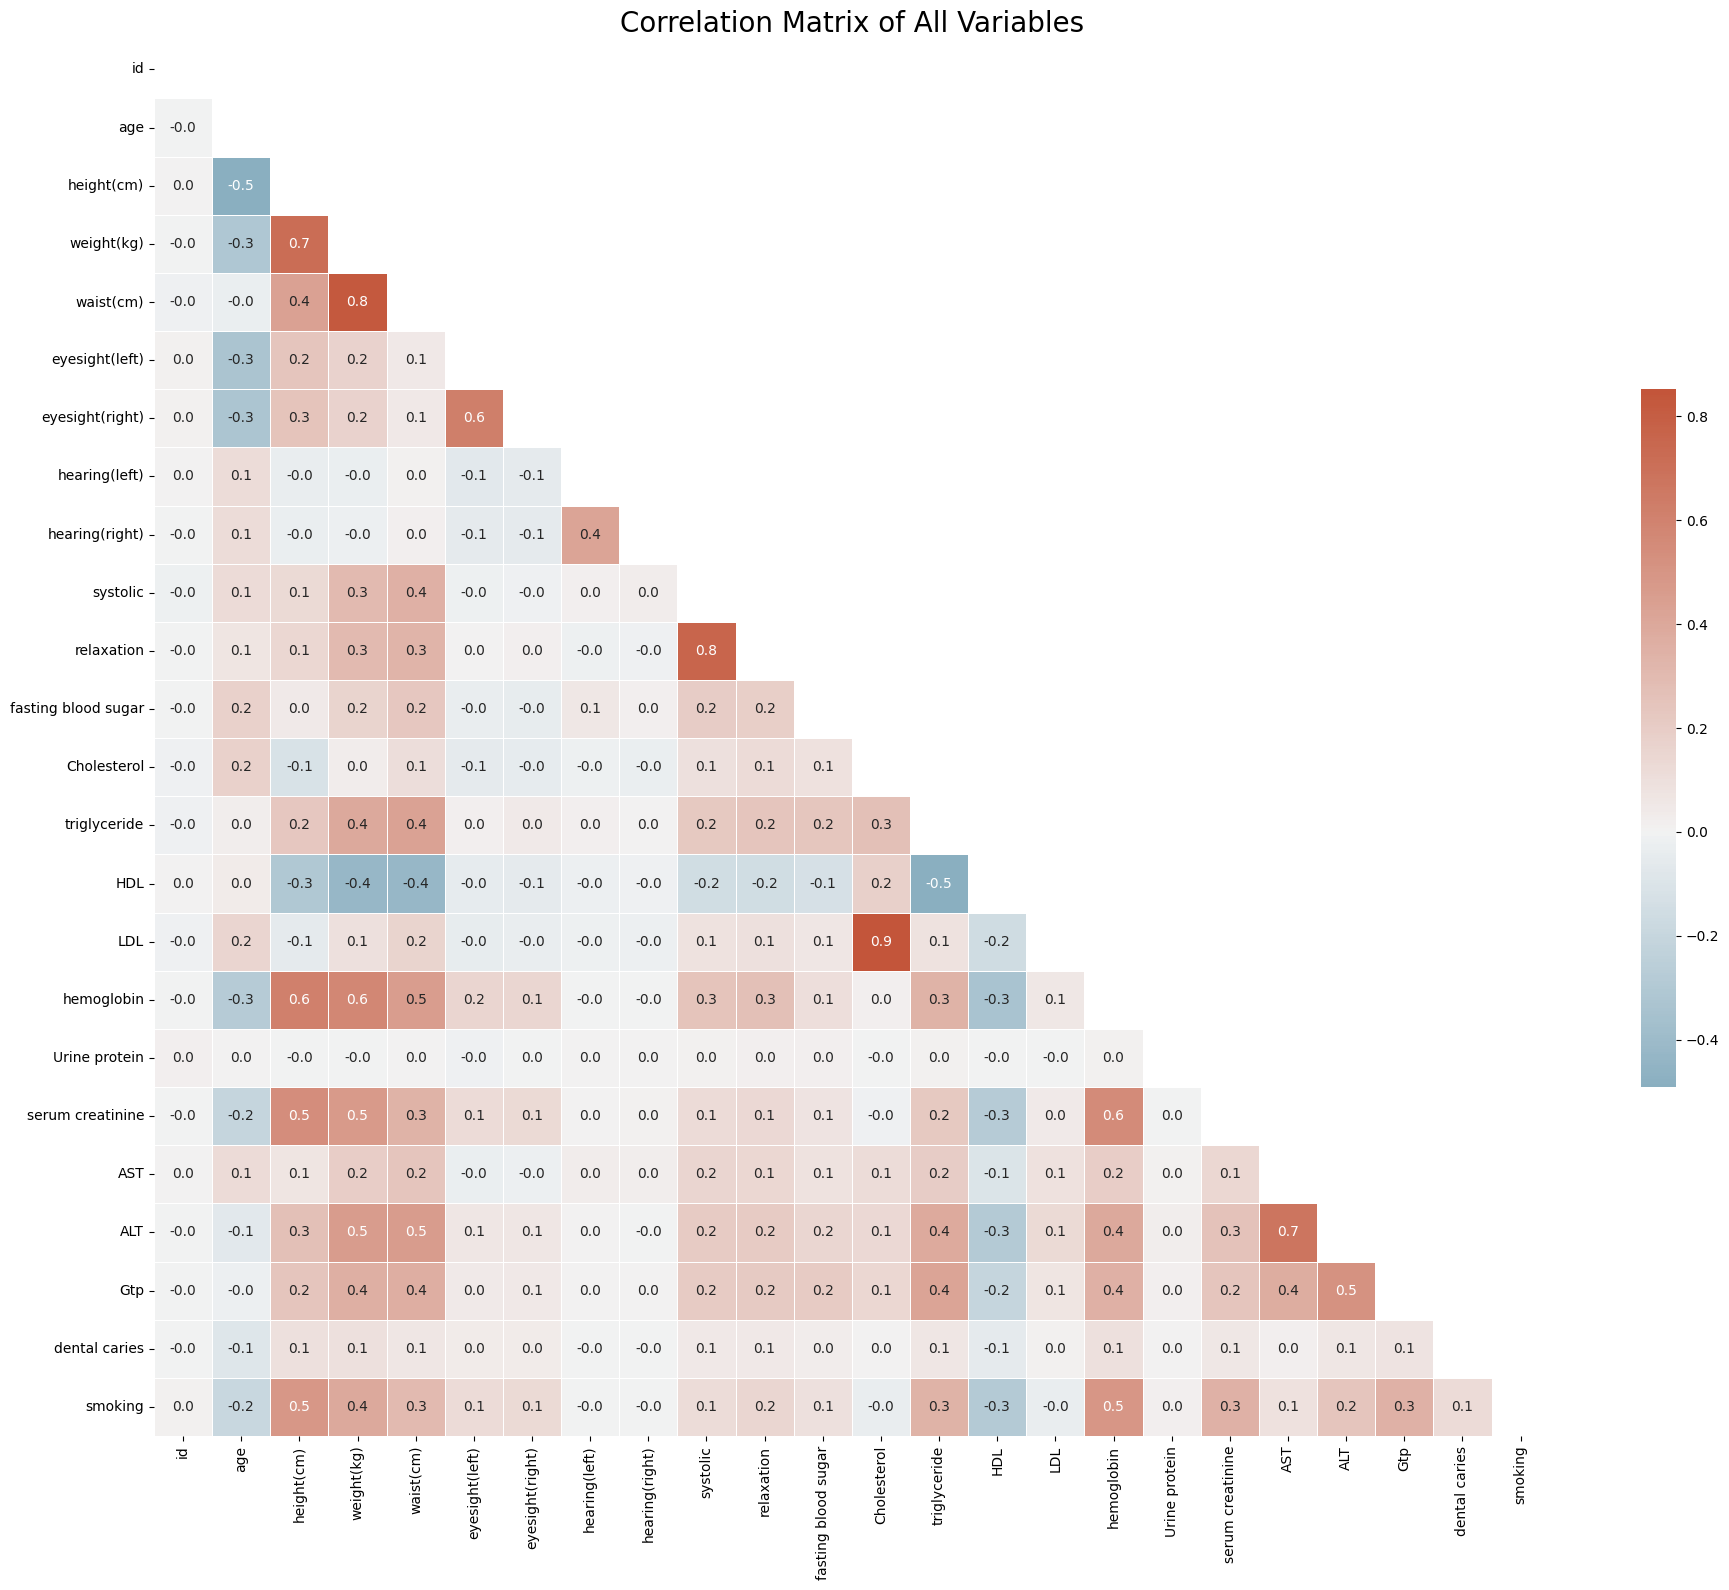

In [32]:
correlation_matrix = train.corr()

plt.figure(figsize=(20, 16))
mask = np.zeros_like(correlation_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, annot=True, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, fmt='.1f')
plt.title('Correlation Matrix of All Variables', fontsize=20)
plt.tight_layout()
plt.show()

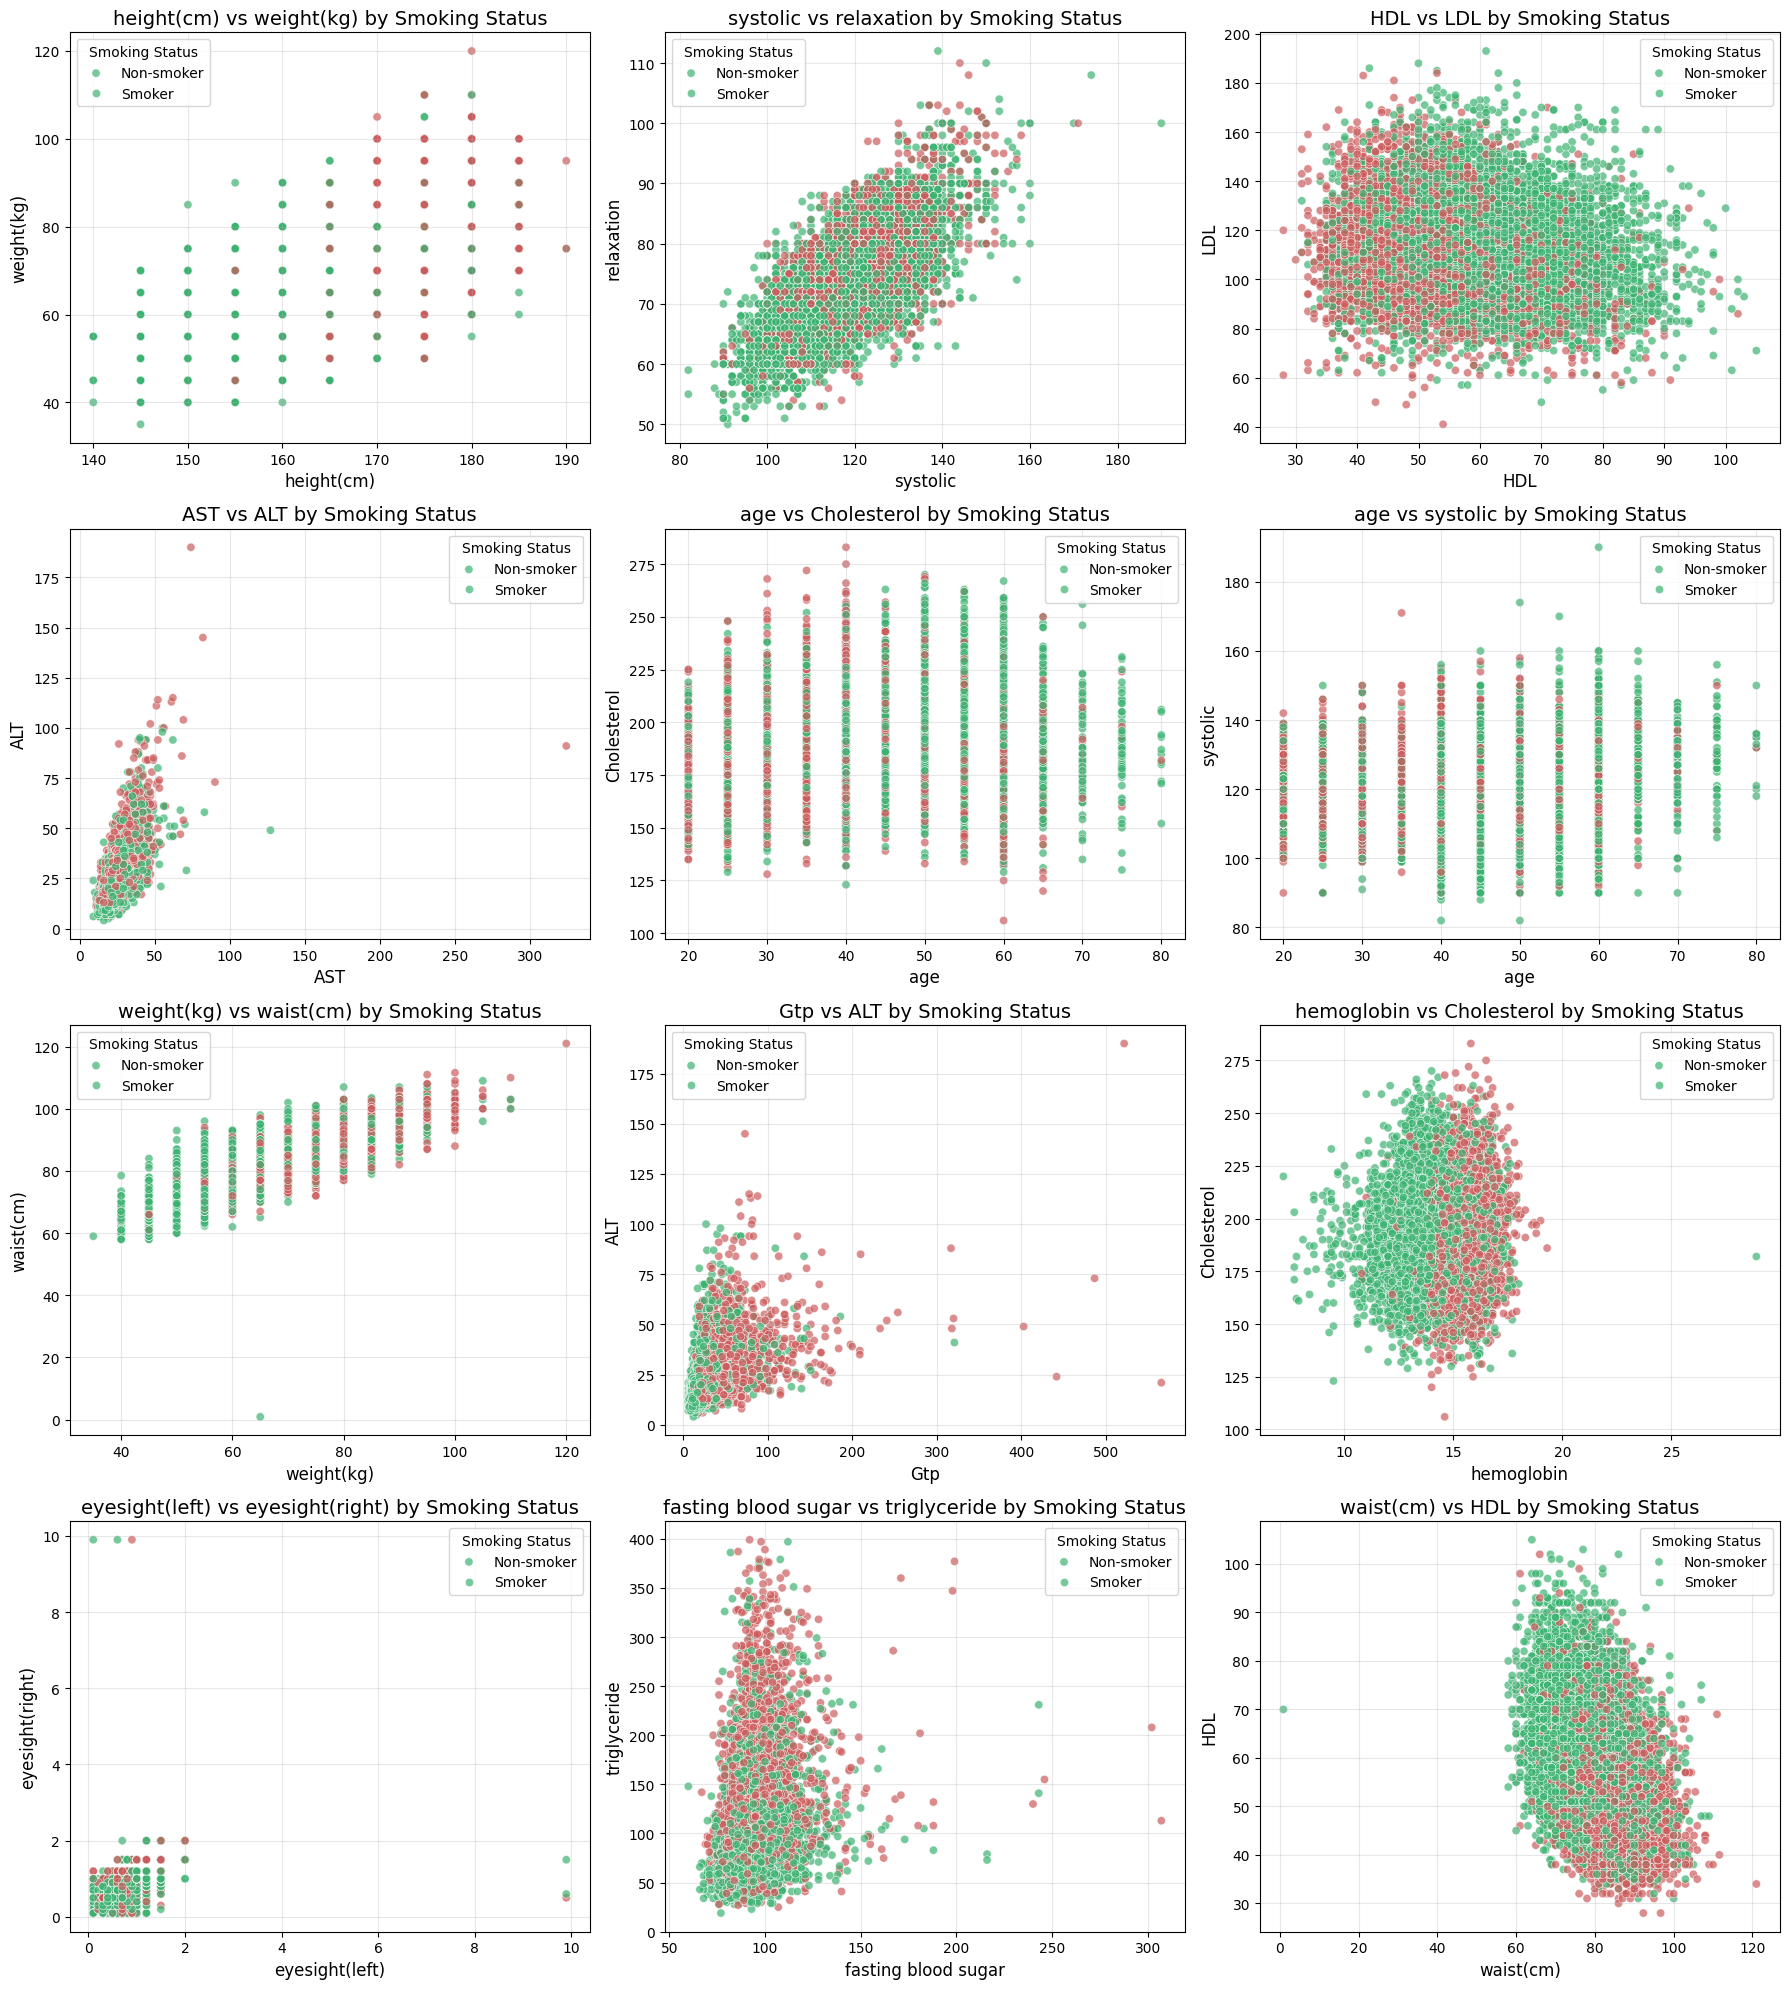

In [33]:
pairs_to_visualize = [
    ('height(cm)', 'weight(kg)'),
    ('systolic', 'relaxation'),
    ('HDL', 'LDL'),
    ('AST', 'ALT'),
    ('age', 'Cholesterol'),
    ('age', 'systolic'),
    ('weight(kg)', 'waist(cm)'),
    ('Gtp', 'ALT'),
    ('hemoglobin', 'Cholesterol'),
    ('eyesight(left)', 'eyesight(right)'),
    ('fasting blood sugar', 'triglyceride'),
    ('waist(cm)', 'HDL')
]

rows = int(np.ceil(len(pairs_to_visualize) / 3))
plt.figure(figsize=(18, rows * 5))

for i, (feature1, feature2) in enumerate(pairs_to_visualize, 1):
    plt.subplot(rows, 3, i)
    sns.scatterplot(x=feature1, y=feature2, hue='smoking', data=train, palette=['#3CB371', '#CD5C5C'], alpha=0.7)
    plt.title(f'{feature1} vs {feature2} by Smoking Status', fontsize=14)
    plt.xlabel(feature1, fontsize=12)
    plt.ylabel(feature2, fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(['Non-smoker', 'Smoker'], title='Smoking Status')

plt.tight_layout()
plt.show()

**Вывод по EDA**

*   Удалим столбец id, так как он не содержит полезной
*   Для улучшения работы моделей добавим новые признаки
*   Применим логарифмическое преобразование (log1p) для скошенных признаков
*   Выполним клипирование значений числовых признаков по 1% и 99% квантилям, чтобы уменьшить влияние выбросов, оставив значения в пределах нормального диапазона
*   Таргет имеет дисбаланс классов, что может негативно повлиять на результаты моделирования. Для решения этой проблемы применим метод SMOTE, который генерирует синтетические образцы для недостаточно представленных классов.
Для кросс-валидации используем StratifiedKFold, чтобы сохранить пропорции классов в каждом фолде, что позволяет избежать проблемы, когда в некоторых фолдах может не быть представлен редкий класс.

## Создание новых признаков

In [34]:
def add_features(df):
    df = df.copy()

    skewed_cols = [
        'hearing(right)', 'hearing(left)', 'Urine protein', 'AST',
        'Gtp', 'eyesight(left)', 'eyesight(right)', 'fasting blood sugar',
        'ALT', 'dental caries', 'triglyceride'
    ]
    for col in skewed_cols:
        df[f'log1p_{col}'] = np.log1p(np.maximum(df[col], 0))

    df['BMI'] = df['weight(kg)'] / (df['height(cm)'] / 100) ** 2
    df['waist_height_ratio'] = df['waist(cm)'] / df['height(cm)']

    df['pulse_pressure'] = df['systolic'] - df['relaxation']
    df['mean_arterial_pressure'] = df['relaxation'] + df['pulse_pressure'] / 3

    df['cholesterol_hdl_ratio'] = df['Cholesterol'] / (df['HDL'] + 1e-3)
    df['ldl_hdl_ratio'] = df['LDL'] / (df['HDL'] + 1e-3)
    df['non_hdl_chol'] = df['Cholesterol'] - df['HDL']

    df['de_ritis_ratio'] = df['AST'] / (df['ALT'] + 1e-3)
    df['liver_function_index'] = (df['AST'] + df['ALT'] + df['Gtp']) / 3

    df['atherogenic_index'] = np.log10(df['triglyceride'] / (df['HDL'] + 1e-3))

    health_cols = ['BMI', 'waist_height_ratio', 'fasting blood sugar',
                   'cholesterol_hdl_ratio', 'triglyceride', 'mean_arterial_pressure']
    df['metabolic_health_index'] = np.mean(df[health_cols], axis=1)

    return df

## Предобработка данных

In [35]:
def preprocess_dataset(df, is_train=True):
    df = df.copy()

    if 'id' in df.columns:
        df = df.drop(columns=['id'])

    if not is_train:
        return add_features(df)

    clip_cols = df.select_dtypes(include=['number']).columns.tolist()
    for col in clip_cols:
        q1, q99 = df[col].quantile(0.01), df[col].quantile(0.99)
        df[col] = df[col].clip(q1, q99)

    df = add_features(df)

    return df

In [36]:
X_train, y_train = train.drop(columns=['smoking']), train['smoking']

X_train_processed = preprocess_dataset(X_train)
X_test_processed = preprocess_dataset(test, is_train=False)

## Отбор признаков

Для отбора будем использовать случайный лес. Также отбросим признаки, создающие мультиколлинеарность.

In [37]:
def select_important_features(
    X,
    y,
    top_fraction=0.7,
    corr_threshold=0.9,
    random_state=None,
    plot_top_n=20
):
    model = RandomForestClassifier(n_estimators=100, random_state=random_state, n_jobs=-1)
    model.fit(X, y)

    importances = model.feature_importances_
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    n_top = int(len(importance_df) * top_fraction)
    selected_features = importance_df.iloc[:n_top]['feature'].tolist()

    X_selected = X[selected_features].copy()

    corr_matrix = X_selected.corr().abs()

    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > corr_threshold)]

    final_features = [feat for feat in selected_features if feat not in to_drop]
    X_selected = X_selected[final_features]

    plt.figure(figsize=(10, 6))
    sns.barplot(
        x='importance',
        y='feature',
        data=importance_df[importance_df['feature'].isin(final_features)].head(plot_top_n),
        palette="viridis"
    )
    plt.title(f"Топ-{plot_top_n} важных признаков")
    plt.xlabel("Важность")
    plt.ylabel("Признак")
    plt.tight_layout()
    plt.show()

    print(f"Итоговое количество признаков: {X_selected.shape[1]}")
    return final_features

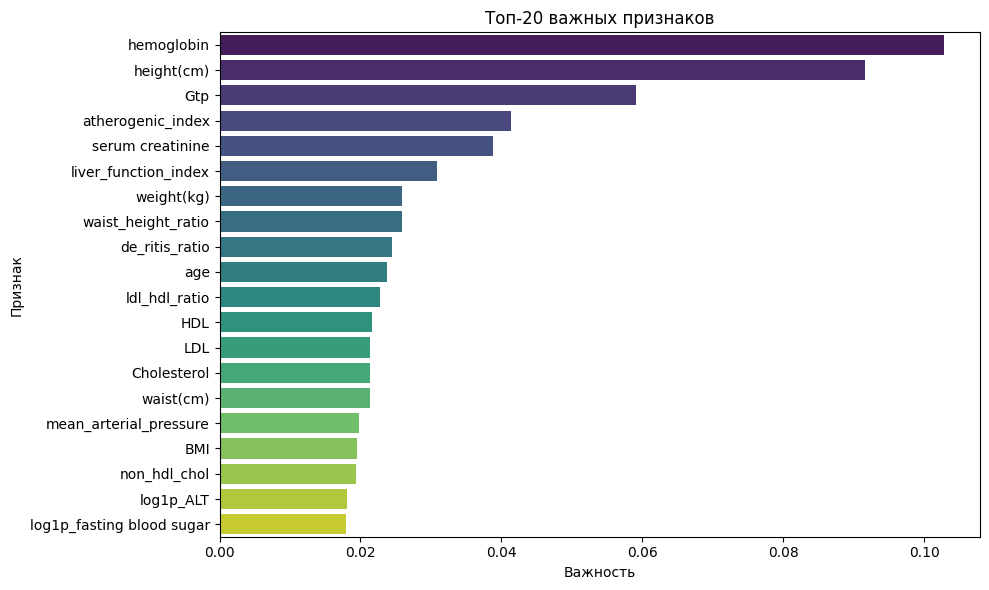

Итоговое количество признаков: 27


In [38]:
selected_features = select_important_features(X_train_processed, y_train, top_fraction=0.95, corr_threshold=0.9)

X_train_processed = X_train_processed[selected_features]
X_test_processed = X_test_processed[selected_features]

## Обучение моделей

Сравним 4 модели:


*   Sklearn реализацию бустинга
*   LightGBM
*   XGBoost
*   CatBoost

Отдельно оценим кастомные реализации бэггинга и бустинга.


In [39]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [40]:
base_clf = DecisionTreeClassifier(max_depth=3, random_state=RANDOM_STATE)

my_bagging_clf = MyBaggingClassifier(base_estimator=base_clf, n_estimators=50, random_state=RANDOM_STATE)
my_gb_clf = MyGradientBoostingClassifier(base_estimator=base_clf, n_estimators=50, learning_rate=0.1)

roc_auc_scores = {}
f1_scores = {}
accuracy_scores = {}
recall_scores = {}
precision_scores = {}

for train_index, test_index in cv.split(X_train_processed, y_train):
    X_cv_train, X_cv_test = X_train_processed.iloc[train_index], X_train_processed.iloc[test_index]
    y_cv_train, y_cv_test = y_train.iloc[train_index], y_train.iloc[test_index]

    my_bagging_clf.fit(X_cv_train, y_cv_train)
    my_gb_clf.fit(X_cv_train, y_cv_train)

    y_my_bagging_clf_pred = my_bagging_clf.predict(X_cv_test)
    y_my_gb_clf_pred = my_gb_clf.predict(X_cv_test)

    roc_auc_bagging = roc_auc_score(y_cv_test, y_my_bagging_clf_pred)
    f1_bagging = f1_score(y_cv_test, y_my_bagging_clf_pred)
    accuracy_bagging = accuracy_score(y_cv_test, y_my_bagging_clf_pred)
    recall_bagging = recall_score(y_cv_test, y_my_bagging_clf_pred)
    precision_bagging = precision_score(y_cv_test, y_my_bagging_clf_pred)

    roc_auc_gb = roc_auc_score(y_cv_test, y_my_gb_clf_pred)
    f1_gb = f1_score(y_cv_test, y_my_gb_clf_pred)
    accuracy_gb = accuracy_score(y_cv_test, y_my_gb_clf_pred)
    recall_gb = recall_score(y_cv_test, y_my_gb_clf_pred)
    precision_gb = precision_score(y_cv_test, y_my_gb_clf_pred)

    roc_auc_scores['Custom Bagging'] = roc_auc_scores.get('Custom Bagging', []) + [roc_auc_bagging]
    f1_scores['Custom Bagging'] = f1_scores.get('Custom Bagging', []) + [f1_bagging]
    accuracy_scores['Custom Bagging'] = accuracy_scores.get('Custom Bagging', []) + [accuracy_bagging]
    recall_scores['Custom Bagging'] = recall_scores.get('Custom Bagging', []) + [recall_bagging]
    precision_scores['Custom Bagging'] = precision_scores.get('Custom Bagging', []) + [precision_bagging]

    roc_auc_scores['Custom Boosting'] = roc_auc_scores.get('Custom Boosting', []) + [roc_auc_gb]
    f1_scores['Custom Boosting'] = f1_scores.get('Custom Boosting', []) + [f1_gb]
    accuracy_scores['Custom Boosting'] = accuracy_scores.get('Custom Boosting', []) + [accuracy_gb]
    recall_scores['Custom Boosting'] = recall_scores.get('Custom Boosting', []) + [recall_gb]
    precision_scores['Custom Boosting'] = precision_scores.get('Custom Boosting', []) + [precision_gb]

for name, scores in roc_auc_scores.items():
    print(f"{name} roc_auc: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")

for name, scores in f1_scores.items():
    print(f"{name} f1: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")

for name, scores in accuracy_scores.items():
    print(f"{name} accuracy: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")

for name, scores in recall_scores.items():
    print(f"{name} recall: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")

for name, scores in precision_scores.items():
    print(f"{name} precision: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")

Custom Bagging roc_auc: 0.7438 (+/- 0.0153)
Custom Boosting roc_auc: 0.7222 (+/- 0.0090)
Custom Bagging f1: 0.6736 (+/- 0.0226)
Custom Boosting f1: 0.6417 (+/- 0.0138)
Custom Bagging accuracy: 0.7650 (+/- 0.0070)
Custom Boosting accuracy: 0.7553 (+/- 0.0055)
Custom Bagging recall: 0.6645 (+/- 0.0511)
Custom Boosting recall: 0.5985 (+/- 0.0273)
Custom Bagging precision: 0.6861 (+/- 0.0137)
Custom Boosting precision: 0.6927 (+/- 0.0117)


In [41]:
models = {
    "Sklearn_GB": GradientBoostingClassifier(random_state=RANDOM_STATE),
    "LightGBM": LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
    "XGBoost": XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1])),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=RANDOM_STATE, auto_class_weights='Balanced')
}

In [42]:
scoring = {
    'roc_auc': 'roc_auc',
    'f1': 'f1',
    'accuracy': 'accuracy',
    'recall': 'recall',
    'precision': 'precision'
}

results = {}

for name, model in models.items():
    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('model', model)
    ])
    scores = cross_validate(pipeline, X_train_processed, y_train,
                             cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)

    results[name] = {
        metric: (np.mean(scores[f'test_{metric}']), np.std(scores[f'test_{metric}']))
        for metric in scoring.keys()
    }

    print(f"\n{name}:")
    for metric, (mean_score, std_score) in results[name].items():
        print(f"  {metric}: {mean_score:.4f} (+/- {std_score:.4f})")

best_model_name = max(results, key=lambda name: results[name]['roc_auc'][0])
print(f"\nЛучшая модель по ROC-AUC на кросс-валидации: {best_model_name}")


Sklearn_GB:
  roc_auc: 0.8820 (+/- 0.0048)
  f1: 0.7485 (+/- 0.0059)
  accuracy: 0.7954 (+/- 0.0049)
  recall: 0.8305 (+/- 0.0139)
  precision: 0.6814 (+/- 0.0084)

LightGBM:
  roc_auc: 0.8827 (+/- 0.0038)
  f1: 0.7411 (+/- 0.0044)
  accuracy: 0.7973 (+/- 0.0043)
  recall: 0.7911 (+/- 0.0067)
  precision: 0.6971 (+/- 0.0078)

XGBoost:
  roc_auc: 0.8742 (+/- 0.0029)
  f1: 0.7393 (+/- 0.0078)
  accuracy: 0.7901 (+/- 0.0070)
  recall: 0.8118 (+/- 0.0123)
  precision: 0.6788 (+/- 0.0103)

CatBoost:
  roc_auc: 0.8850 (+/- 0.0050)
  f1: 0.7422 (+/- 0.0052)
  accuracy: 0.7996 (+/- 0.0053)
  recall: 0.7867 (+/- 0.0090)
  precision: 0.7026 (+/- 0.0102)

Лучшая модель по ROC-AUC на кросс-валидации: CatBoost


Для лучшей модели подберём гиперпараметры с помощью Optuna.

In [43]:
def objective(trial):
    if best_model_name == "LightGBM":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 2000),
            "max_depth": trial.suggest_int("max_depth", 3, 16),
            "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.3),
            "num_leaves": trial.suggest_int("num_leaves", 20, 500),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 200),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
            "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 1.0),
            "class_weight": 'balanced'
        }
        model = LGBMClassifier(**params, random_state=RANDOM_STATE)

    elif best_model_name == "XGBoost":
        scale_pos_weight = (y_train.value_counts()[0] / y_train.value_counts()[1])
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "gamma": trial.suggest_float("gamma", 0, 5),
            "scale_pos_weight": scale_pos_weight
        }
        model = XGBClassifier(**params, random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss')

    elif best_model_name == "CatBoost":
        params = {
            "iterations": trial.suggest_int("iterations", 100, 1200),
            "depth": trial.suggest_int("depth", 3, 9),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.15),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
            "auto_class_weights": 'Balanced'
        }
        model = CatBoostClassifier(**params, verbose=0, random_state=RANDOM_STATE)

    else:
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "max_depth": trial.suggest_int("max_depth", 3, 12),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0)
        }
        model = GradientBoostingClassifier(**params, random_state=RANDOM_STATE)

    pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])

    score = cross_val_score(pipeline, X_train_processed, y_train, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("Best trial:")
print(study.best_trial)

[I 2025-04-28 14:54:55,999] A new study created in memory with name: no-name-6b5de7bd-5936-462b-9221-0d53935f43d8
[I 2025-04-28 14:55:18,512] Trial 0 finished with value: 0.8846251679912737 and parameters: {'iterations': 257, 'depth': 6, 'learning_rate': 0.10507575410200225, 'l2_leaf_reg': 5.95501541174627}. Best is trial 0 with value: 0.8846251679912737.
[I 2025-04-28 14:55:58,742] Trial 1 finished with value: 0.8843641579189878 and parameters: {'iterations': 872, 'depth': 3, 'learning_rate': 0.019924731165890393, 'l2_leaf_reg': 8.431881863745122}. Best is trial 0 with value: 0.8846251679912737.
[I 2025-04-28 14:56:35,522] Trial 2 finished with value: 0.88389459382422 and parameters: {'iterations': 836, 'depth': 3, 'learning_rate': 0.08301715458035802, 'l2_leaf_reg': 5.647445987290836}. Best is trial 0 with value: 0.8846251679912737.
[I 2025-04-28 14:56:46,079] Trial 3 finished with value: 0.8808309237695964 and parameters: {'iterations': 135, 'depth': 5, 'learning_rate': 0.0376451949

Best trial:
FrozenTrial(number=19, state=1, values=[0.8867538571762003], datetime_start=datetime.datetime(2025, 4, 28, 15, 22, 22, 141842), datetime_complete=datetime.datetime(2025, 4, 28, 15, 22, 52, 46766), params={'iterations': 432, 'depth': 5, 'learning_rate': 0.062370894858998965, 'l2_leaf_reg': 9.938266116498765}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'iterations': IntDistribution(high=1200, log=False, low=100, step=1), 'depth': IntDistribution(high=9, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.15, log=False, low=0.01, step=None), 'l2_leaf_reg': FloatDistribution(high=10.0, log=False, low=1.0, step=None)}, trial_id=19, value=None)


In [44]:
final_params = study.best_params

if best_model_name == "LightGBM":
    final_model = LGBMClassifier(**final_params, random_state=RANDOM_STATE)
elif best_model_name == "XGBoost":
    final_model = XGBClassifier(**final_params, random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss')
elif best_model_name == "CatBoost":
    final_model = CatBoostClassifier(**final_params, verbose=0, random_state=RANDOM_STATE)
else:
    final_model = GradientBoostingClassifier(**final_params, random_state=RANDOM_STATE)

final_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('model', final_model)
])

final_pipeline.fit(X_train_processed, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x7e2ab5fd8a50>)])

In [45]:
y_test_pred_proba = final_pipeline.predict_proba(X_test_processed)[:, 1]

submission = pd.DataFrame({"id": test['id'], "smoking": y_test_pred_proba})
submission.to_csv("submission.csv", index=False)